# Подготовка набора данных

In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as lin
import itertools
import random
import warnings

from tqdm import tqdm
from math import sqrt
from typing import TYPE_CHECKING
from __future__ import annotations
from typing import List, Tuple

warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

In [2]:
"""Реализация алгоритма AUMP."""
def aump(input_image: np.ndarray, m: int, d: int) -> float:
    """
    AUMP НЗБ детектор.

    :param input_image - входное изображение.
    :param m - размер окна в пикселях.
    :param d = q - 1 - степень полинома для прогонки.

    :return beta - статистика обнаружения.
    """
    image = input_image.astype(np.float64)
    image_pred, _, weights = predict_aump(image, m, d)  # полиномиальное предсказание, веса
    residual = image - image_pred  # вычет
    X_bar = (image + 1) - 2 * np.mod(image, 2)  # переворот
    beta = np.sum(np.multiply(np.multiply(weights, (image - X_bar)), residual))  # статистика обнаружения
    return beta

def predict_aump(image_input: np.ndarray, m: int, d: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Предсказатель пикселей путем подгонки локального полинома степени d = q - 1.
    m должно разделить количество пикселей в строке.

    :param image_input - изображение для предсказания.
    :param m - размер окна в пикселях.
    :param d = q - 1 - степень полинома для прогонки.

    :return image_pred - предсказанное изображение.
    :return sigma - локальные различия.
    :return weights - веса.
    """
    input_image_rows, input_image_cols = image_input.shape

    sig_th = 1
    q = d + 1
    k_n = (input_image_rows * input_image_cols) // m  # количество блоков в m пикселях
    y = np.zeros((m, k_n))  # y хранит все блоки пикселей в колонках
    S = np.zeros_like(image_input)  # межпиксельное различие
    image_pred = np.zeros_like(image_input)  # предсказанное изображение
    flatten_image = image_input.flatten("F")

    H = np.zeros((m, q))
    x1: np.ndarray = np.arange(1, m + 1) / m

    for i in range(0, q):
        H[:, i] = np.power(x1.T, i)

    for i in range(1, m + 1):  # формируем блоки пикселей
        # aux = image_input[:, i::m]
        if i != m:
            aux = flatten_image[(i - 1) * k_n:i * k_n]
        else:
            aux = flatten_image[(i - 1) * k_n:]
        y[i-1] = aux

    p = lin.lstsq(H, y)[0]
    y_pred = H @ p

    for i in range(0, m):
        image_pred[:, i::m] = np.reshape(y_pred[i, :], image_input[:, i::m].shape)

    sig2 = np.sum(np.power(y - y_pred, 2), axis=0) / (m - q)
    sig2 = np.maximum((sig_th ** 2) * np.ones_like(sig2.shape), sig2)

    Sy = np.ones((m, 1)) * sig2

    for i in range(0, m):
        S[:, i::m] = np.reshape(Sy[i, :], image_input[:, i::m].shape)

    s_n2 = k_n / np.sum(1/sig2)

    S[S == 0] = 1 # защита от деления на ноль

    w = sqrt(s_n2 / (k_n * (m-q))) / S

    return image_pred, S, w


def predict_aump_old(
    image_input: np.ndarray,
    m: int,
    d: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Предсказатель пикселей путем подгонки локального полинома степени d = q - 1.
    m должно разделить количество пикселей в строке.

    :param image_input - изображение для предсказания.
    :param m - размер окна в пикселях.
    :param d = q - 1 - степень полинома для прогонки.

    :return image_pred - предсказанное изображение.
    :return sigma - локальные различия.
    :return weights - веса.
    """
    input_image_rows, input_image_cols = image_input.shape

    signum_threshold = 1  # порог численной сходимости
    q = d + 1  # количество параметров на каждый блок
    k_n = (input_image_rows * input_image_cols) // m  # количество блоков в m пикселях
    y = np.zeros((m, k_n))  # y хранит все блоки пикселей в колонках
    sigma = np.zeros_like(image_input)  # межпиксельное различие
    image_pred = np.zeros_like(image_input)  # предсказанное изображение
    flatten_image = image_input.flatten("F")  # колонно-ориентированное сплющивание

    vandermonde_matrix = np.zeros((m, q))  # матрица Вандермонда
    x_1: np.ndarray = np.arange(1, m + 1) / m
    for i in range(1, q + 1):
        vandermonde_matrix[:, i - 1] = np.power(x_1.T, i - 1)

    for i in range(1, m + 1):  # формируем блоки пикселей
        if i != m:
            aux = flatten_image[(i - 1) * k_n:i * k_n]
        else:
            aux = flatten_image[(i - 1) * k_n:]
        y[i-1] = aux

    polynomial = np.zeros_like(y).astype(np.float64)
    operations = k_n // q
    # поблочное деление матрицы блоков пикселей на матрицу Вандермонда
    for num_operation in range(1, operations + 1):
        y_part = y[:, (num_operation - 1) * q:num_operation * q]
        aux = y_part / vandermonde_matrix
        polynomial[:, (num_operation - 1) * q:num_operation * q] = aux

    polynomial = np.nan_to_num(polynomial)
    y_pred = np.zeros_like(y).astype(np.float64)
    # поблочное умножение матрицы полиномов на матрицу Вандермонда
    for num_operation in range(1, operations + 1):
        polynomial_part = polynomial[:, (num_operation - 1) * q:num_operation * q]
        aux = vandermonde_matrix * polynomial_part
        y_pred[:, (num_operation - 1) * q:num_operation * q] = aux

    flatten_y_pred = np.nan_to_num(y_pred).flatten()  # построчно-ориентированное сплющивание
    for i in range(1, input_image_cols + 1):
        if i != input_image_cols:
            aux = flatten_y_pred[(i - 1) * input_image_rows:i * input_image_rows]
        else:
            aux = flatten_y_pred[(i - 1) * input_image_rows:]
        image_pred[:, i-1] = aux

    sigma_2 = np.sum((y - y_pred) ** 2, axis=0) / (m - q)  # различие в k-м блоке
    le01 = signum_threshold ** 2 * np.ones(sigma_2.shape)
    sigma_2 = le01 if np.all(le01 >= sigma_2) else sigma_2

    sigma_y = np.ones((m, 1)) * sigma_2  # различие во всех пикселях
    flatten_sigma_y = sigma_y.flatten()
    for i in range(1, input_image_cols + 1): # преобразуем к размеру входного изображения
        if i != input_image_cols:
            aux = flatten_sigma_y[(i - 1) * input_image_rows:i * input_image_rows]
        else:
            aux = flatten_sigma_y[(i - 1) * input_image_rows:]
        sigma[:, i-1] = aux

    sigma_n2 = k_n / np.sum(1 / sigma_2)
    weights = np.sqrt(sigma_n2 / (k_n * (m - q))) / sigma  # веса

    return image_pred, sigma, weights

In [3]:
def get_binary_plane(image: np.ndarray, binary_num: int) -> np.ndarray:
    """Выдача битовой плоскости определенного порядка"""
    num = 2 ** (binary_num - 1)
    return np.bitwise_and(image, num)

def set_binary_value(pixel: int, value: int, binary_num: int, image_bits: int = 8) -> int:
    """Заменяет значение в бите."""
    max_bits = 2 ** image_bits - 1
    copy_number = pixel & (max_bits ^ (1 << (binary_num - 1)))
    new_pixel_value = copy_number + (value << (binary_num - 1))
    return new_pixel_value

def white_noise(q: float, n1: int, n2: int) -> np.ndarray:
    """Генерация белого шума."""
    nb = int(n1 * n2 * q)
    return np.random.randint(0, 2, size=(nb, ), dtype=np.uint8)

def get_random_image_coordinates(image: np.ndarray, size: int) -> List[Tuple[int, int]]:
    """Генерация случайных координат изображений."""
    n_rows, n_cols = image.shape
    pixels_combinations = list(itertools.product(range(n_rows), range(n_cols)))
    return random.sample(pixels_combinations, size)

def lsb_replacement(image: np.ndarray, q: float, binary_num: int = 1) -> np.ndarray:
    """НЗБ-встраивание по псевдослучайным координатам."""
    noise_image: np.ndarray = image.copy()
    rows, cols = noise_image.shape
    noise_vector = white_noise(q, rows, cols)
    noise_vector_len = len(noise_vector)
    random_coordinates = get_random_image_coordinates(noise_image, noise_vector_len)
    for index, pixel_coordinate in enumerate(random_coordinates):
        i, j = pixel_coordinate
        noise_image[i][j] = set_binary_value(noise_image[i][j], noise_vector[index], binary_num)
    return noise_image

## Исходные параметры для генерации набора данных

In [4]:
# Параметры для AUMP
PIXEL_SIZE = 128  # размер окна в пикселях
POLYNOMIAL_DEGREE = 7  # степень полинома для прогонки

# Параметры для НЗБ-встраивания
BINARY_NUM = 2  # 2-я битовая плоскость

In [5]:
# Зашумлённость
Q = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [6]:
# Пути к директориям с исходными изображениями и набору данных
IMAGES_DIR = "./images"
DATASETS_DIR = "./datasets"

In [7]:
# Набор изображений
files = glob.glob(IMAGES_DIR + "/**/*.tif", recursive=True)
print("\n".join(files))

./images\Image00001.tif
./images\Image00002.tif
./images\Image00003.tif
./images\Image00004.tif
./images\Image00005.tif
./images\Image00006.tif
./images\Image00007.tif
./images\Image00008.tif
./images\Image00009.tif
./images\Image00010.tif
./images\Image00011.tif
./images\Image00012.tif
./images\Image00013.tif
./images\Image00014.tif
./images\Image00015.tif
./images\Image00016.tif
./images\Image00017.tif
./images\Image00018.tif
./images\Image00019.tif
./images\Image00020.tif
./images\Image00021.tif
./images\Image00022.tif
./images\Image00023.tif
./images\Image00024.tif
./images\Image00025.tif
./images\Image00026.tif
./images\Image00027.tif
./images\Image00028.tif
./images\Image00029.tif
./images\Image00030.tif
./images\Image00031.tif
./images\Image00032.tif
./images\Image00033.tif
./images\Image00034.tif
./images\Image00035.tif
./images\Image00036.tif
./images\Image00037.tif
./images\Image00038.tif
./images\Image00039.tif
./images\Image00040.tif
./images\Image00041.tif
./images\Image00

## Вспомогательные функции

In [8]:
def plot_grayscale_image(input_image: np.ndarray, title: str = None) -> None:
    """Отрисовка изображения в оттенках серого."""
    if title:
        plt.title(title)
    plt.imshow(input_image, cmap='gray')
    plt.axis("off")

## Пример работы

In [9]:
image_sample = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)
image_sample.shape

(512, 512)

In [10]:
assert np.prod(image_sample.shape) % PIXEL_SIZE == 0, "Поменять значение PIXEL_SIZE"

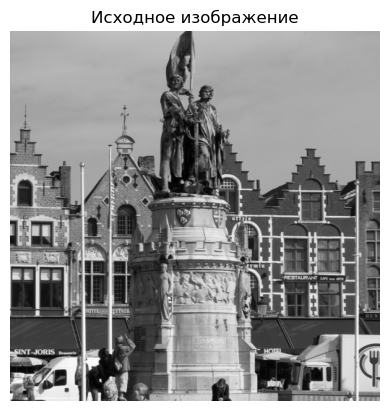

In [11]:
plot_grayscale_image(image_sample, "Исходное изображение")

In [12]:
%%time
lsb_image = lsb_replacement(image_sample, q=0.8, binary_num=BINARY_NUM)

Wall time: 1.42 s


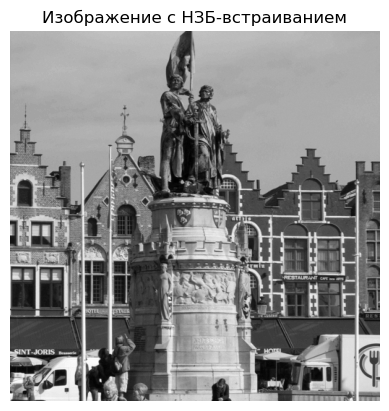

In [13]:
plot_grayscale_image(lsb_image, "Изображение с НЗБ-встраиванием")

In [14]:
binary_plane_image = get_binary_plane(image_sample, BINARY_NUM)
binary_plane_lsb_image = get_binary_plane(lsb_image, BINARY_NUM)
differences = binary_plane_image != binary_plane_lsb_image

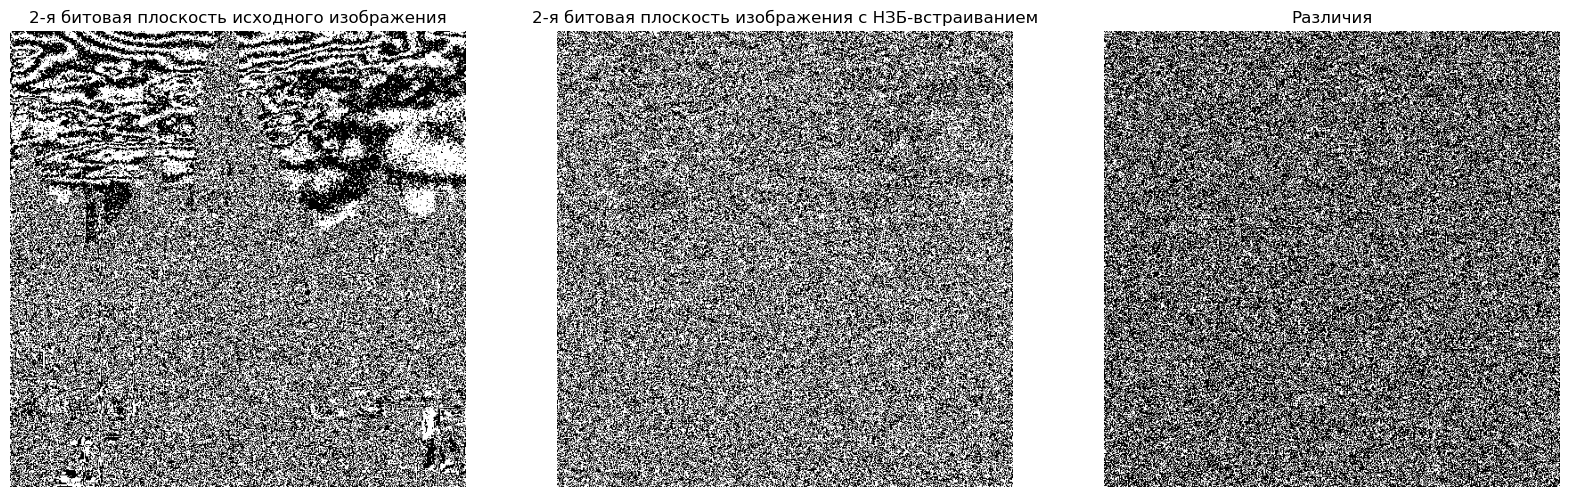

In [15]:
plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plot_grayscale_image(binary_plane_image, f"{BINARY_NUM}-я битовая плоскость исходного изображения")

plt.subplot(1, 3, 2)
plot_grayscale_image(binary_plane_lsb_image, f"{BINARY_NUM}-я битовая плоскость изображения с НЗБ-встраиванием")

plt.subplot(1, 3, 3)
plot_grayscale_image(differences, "Различия")

In [16]:
# Вектор признаков при помощи AUMP
aump(lsb_image, m=PIXEL_SIZE, d=POLYNOMIAL_DEGREE)

0.9764705051959951

## Создание набора данных

In [17]:
files_with_lsb = files[:int(0.5 * len(files))]
files_without_lsb = files[int(0.5 * len(files)):]

In [18]:
datasets = {}

In [19]:
for q in Q:
    print(f"Зашумленность: {q}")
    datasets[q] = {}
    datasets[q]["with_lsb"] = []
    datasets[q]["without_lsb"] = []
    for file_ in tqdm(files):
        image_ = cv2.imread(file_, cv2.IMREAD_GRAYSCALE)
        if file_ in files_with_lsb:
            datasets[q]["with_lsb"].append(
                aump(
                    input_image=lsb_replacement(image_, q=q, binary_num=BINARY_NUM),
                    m=PIXEL_SIZE,
                    d=POLYNOMIAL_DEGREE,
                )
            )
        else:
            datasets[q]["without_lsb"].append(aump(image_, m=PIXEL_SIZE, d=POLYNOMIAL_DEGREE))

Зашумленность: 0.2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:27<00:00,  3.74it/s]


Зашумленность: 0.3


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:44<00:00,  2.91it/s]


Зашумленность: 0.4


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:06<00:00,  2.34it/s]


Зашумленность: 0.5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:58<00:00,  1.86it/s]


Зашумленность: 0.6


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:30<00:00,  1.59it/s]


Зашумленность: 0.7


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:40<00:00,  1.43it/s]


Зашумленность: 0.8


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:17:23<00:00, 11.84s/it]


Зашумленность: 0.9


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:24:23<00:00,  5.06s/it]


Зашумленность: 1.0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:25<00:00,  1.01it/s]


In [26]:
aump_datasets_dir = DATASETS_DIR + "/aump"

In [27]:
for q_ in datasets.keys():
    dataset_name = aump_datasets_dir + f"/data_{str(q_).replace('.', '_')}.csv"
    with_lsb = datasets[q_]["with_lsb"]
    without_lsb = datasets[q_]["without_lsb"]
    features = with_lsb[0]

    columns = [f"feature_{i}" for i in range(len(features))]  if type(features) == list else ["feature_1"]
    with_lsb_df = pd.DataFrame(data=with_lsb, columns=columns)
    with_lsb_df["target"] = 1
    without_lsb_df = pd.DataFrame(data=without_lsb, columns=columns)
    without_lsb_df["target"] = 0

    result_df = pd.concat([with_lsb_df, without_lsb_df])
    result_df.to_csv(dataset_name, index=False)